## Demo of iN-NMF on a hybrid T-F representation

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as pyp
import numpy as np
import scipy
import tqdm

from utils import *
from models import innmf_WH_both

In [2]:
from matplotlib.pylab import register_cmap, rc
from matplotlib.colors import LinearSegmentedColormap
cdict = {
    'red':   ((0.0,  1.0, 1.0), (1.0,  0.0, 0.0)),
    'green': ((0.0,  1.0, 1.0), (1.0,  .15, .15)),
    'blue':  ((0.0,  1.0, 1.0), (1.0,  0.4, 0.4)),
    'alpha': ((0.0,  0.0, 0.0), (1.0,  1.0, 1.0))}
register_cmap( cmap=LinearSegmentedColormap( 'InvBlueA', cdict))
rc( 'image', cmap='InvBlueA')

/tmp/ipykernel_51145/3480872994.py:8: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  register_cmap( cmap=LinearSegmentedColormap( 'InvBlueA', cdict))


In [3]:
# Decorator to optimize CUDA calls
def cudagraph( f):
    _graphs = {}
    def f_( *args):
        key = hash( tuple( tuple( a.shape) for a in args))
        if key in _graphs:
            wrapped, *_ = _graphs[key]
            return wrapped( *args)

        g = torch.cuda.CUDAGraph()
        in_tensors = [a.clone() for a in args]
        f( *in_tensors) # stream warmup

        with torch.cuda.graph( g):
            out_tensors = f( *in_tensors)

        def wrapped( *args):
            [a.copy_(b) for a, b in zip( in_tensors, args)]
            g.replay()
            return out_tensors

        _graphs[key] = (wrapped, g, in_tensors, out_tensors)
        return wrapped( *args)

    return f_

/tmp/ipykernel_51145/2238076849.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,s = scipy.io.wavfile.read('./learnerspiano_low_octave.wav')


Text(0, 0.5, 'Amplitude')

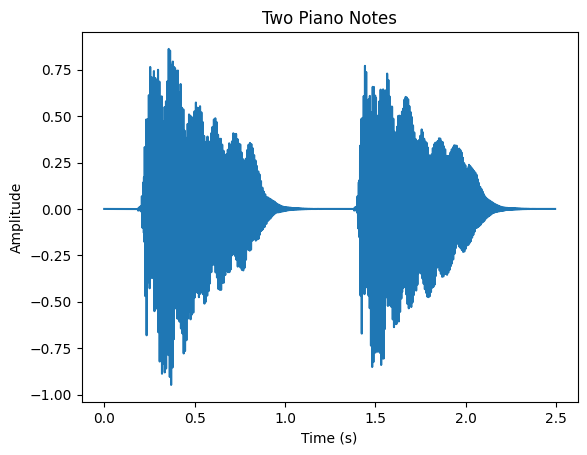

In [4]:
sr,s = scipy.io.wavfile.read('./learnerspiano_low_octave.wav')
s = s[:11000*10,0]/(2**15 - 1)
s = scipy.signal.resample_poly(s,1,10)
sr = sr/10

pyp.title("Two Piano Notes")
pyp.plot(np.arange(s.shape[0])/sr,s)
pyp.xlabel('Time (s)')
pyp.ylabel('Amplitude')

In [32]:
# Construct Hybrid T-F Representation of 2 different STFT sizes

m_1,t_1,f_1,farr_1= stft(s,N = 128,H = 32,sr = sr)
# m_1 = m_1/m_1.max()
mat_1 = m_1.reshape(farr_1.shape[0],-1)
m_2,t_2,f_2,farr_2= stft(s,N = 1024,H = 256,sr = sr)
# m_2 = m_2/m_2.max()
mat_2 = m_2.reshape(farr_2.shape[0],-1)
m_3,t_3,f_3,_,farr_cqt= cqt(s,Q = 64,B = 64,H = 128,sr = sr,num_octaves=6.7,f_min=20)
# m_3 = m_3/m_2.max()

Text(0, 0.5, 'Frequency (Hz)')

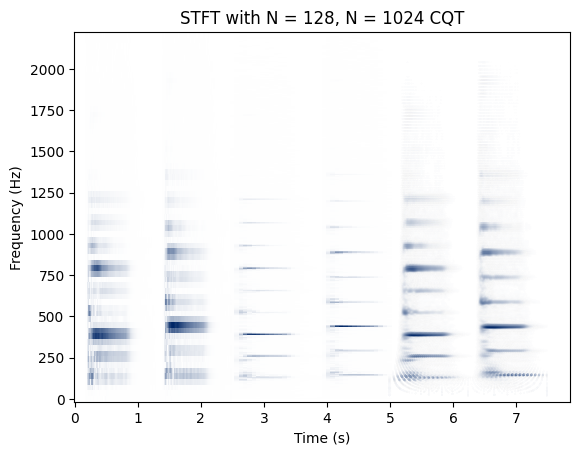

In [33]:
pyp.title("STFT with N = 128, N = 1024, CQT")
pyp.pcolormesh(np.linspace(0,t_1.max(),mat_1.shape[-1]),farr_1,mat_1**0.5,shading='nearest', lw=.1, antialiased=True,cmap='InvBlueA')
pyp.pcolormesh(s.shape[0]/sr + np.linspace(0,t_2.max(),mat_2.shape[-1]),farr_2,mat_2**0.5,shading='nearest', lw=.1, antialiased=True,cmap='InvBlueA')
pyp.scatter(2*s.shape[0]/sr + t_3,f_3,c = m_3**0.5,s = m_3**0.5,cmap='InvBlueA')
pyp.xlabel('Time (s)')
pyp.ylabel('Frequency (Hz)')

In [34]:
t_concat = np.concatenate([t_1,s.shape[0]/sr + t_2,2*s.shape[0]/sr + t_3])
tdur = t_concat.max()
f_concat = np.concatenate([f_1,f_2,f_3])
m_concat = np.concatenate([m_1,m_2,m_3])

tinds_unroll = torch.from_numpy(t_concat/tdur).to(device)
finds_unroll = torch.from_numpy(f_concat/(sr/2)).to(device)
mag_unroll = torch.from_numpy(m_concat**0.5).to(device)

In [35]:
rank = 2
learning_rate = 1.0e-3
nmf_net_wh = innmf_WH_both(N = 128,Npos = 10,hidden_size = 16,rank = rank,trainable = False).to(device)
optim_WH = torch.optim.Rprop(nmf_net_wh.parameters(), lr=learning_rate)

In [36]:
@cudagraph
def train_new( spec_x, finds, tinds):
    optim_WH.zero_grad(set_to_none=True)
    xhat = nmf_net_wh(finds,tinds)
    loss_H = torch.mean((spec_x*(torch.log((spec_x + 1.0e-8)/(xhat + 1.0e-8))) - spec_x + xhat))
    loss_H.backward()
    optim_WH.step()

    return loss_H

In [37]:
num_epochs = 1000
loss_epoch = []
for i in tqdm.trange(num_epochs):
    # Training with a random subset of points to speedup
    randint = torch.randperm(mag_unroll.shape[0])[:(int)(0.5*mag_unroll.shape[0])].to(device)
    loss_H = train_new(mag_unroll[randint],finds_unroll[randint],tinds_unroll[randint])
    loss_epoch.append(loss_H.item())


100%|██████████| 1000/1000 [09:59<00:00,  1.67it/s]


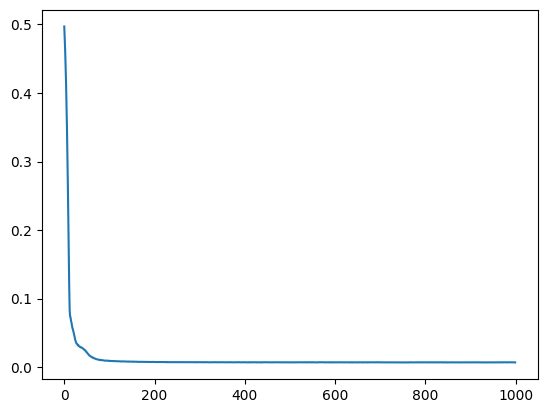

In [38]:
pyp.plot(loss_epoch)

In [39]:
f = torch.from_numpy(farr_2)/(sr/2)
list_W = nmf_net_wh.get_W(f).detach().cpu()

t = torch.from_numpy(np.linspace(0,tdur,100)/tdur)
list_H = nmf_net_wh.get_H(t).detach().cpu()

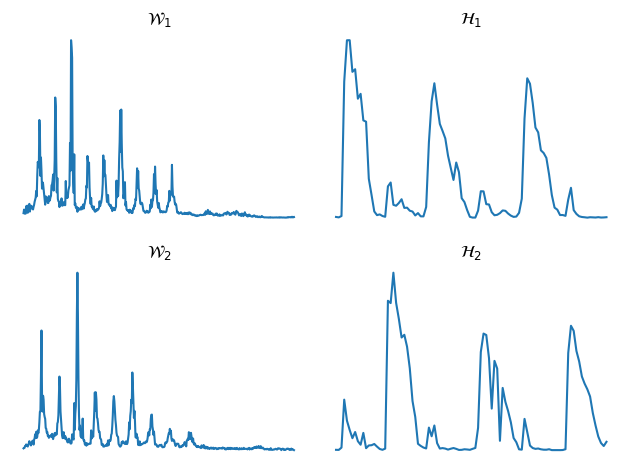

In [40]:
for i in range(rank):
        pyp.subplot(rank,2,2*i+1)
        pyp.title('$\mathcal{W}_' + str(i+1) + '$')
        pyp.plot(f.detach().cpu().numpy(),list_W[:,i])
        pyp.axis('off')
        pyp.subplot(rank,2,2*i+2)
        pyp.title('$\mathcal{H}_' + str(i+1) + '$')
        pyp.plot(t.detach().cpu().numpy(),list_H[i,:])
        pyp.axis('off')
pyp.tight_layout()